# Quantisation

https://pytorch.org/blog/introduction-to-quantization-on-pytorch/

https://pytorch.org/docs/stable/quantization.html

https://www.onnxruntime.ai/docs/

https://towardsdatascience.com/why-you-should-convert-your-nlp-pipelines-to-onnx-2c4a3433325f#:~:text=ONNX%20Runtime's%20built%2Din%20graph,integers%20from%20floating%20point%20decimals).

## Introduction

### Quantisation

### Static Quantisation

### Dynamic Quantisation

## Imports

In [44]:
import sys
!{sys.executable} -m pip install --upgrade torch==1.6.0 torchvision==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 552.8 MB 29 kB/s s eta 0:00:01
     |████████████████████████████████| 5.8 MB 475 kB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.6.0+cpu
    Uninstalling torch-1.6.0+cpu:
      Successfully uninstalled torch-1.6.0+cpu
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.7.0+cpu
    Uninstalling torchvision-0.7.0+cpu:
      Successfully uninstalled torchvision-0.7.0+cpu
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

fastai 2.1.5 requires torch>=1.7.0, but you'll have torch 1.6.0+cu92 which is incompatible.
fastai 2.1.5 requires torchvision>=0.8, but you'll have torch

In [1]:
# run before onnx import
from os import environ
from psutil import cpu_count
environ["OMP_NUM_THREADS"] = str(cpu_count(logical=True))
environ["OMP_WAIT_POLICY"] = 'ACTIVE'

In [2]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from time import time
from contextlib import contextmanager
from tqdm import trange
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

## ONNX Imports & Utils

In [3]:
from transformers.convert_graph_to_onnx import convert, quantize
from onnxruntime_tools import optimizer
from onnxruntime_tools.transformers.onnx_model_bert import BertOptimizationOptions
from onnxruntime import GraphOptimizationLevel, InferenceSession, SessionOptions, get_all_providers

def create_model_for_provider(model_path, provider): 
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL

    session = InferenceSession(model_path, options, providers=[provider])
    session.disable_fallback()
    return session

class ONNXPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
    def __call__(self, prompt):
        model_inputs = self.tokenizer(prompt, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy() for k, v in model_inputs.items()}
        return self.model.run(None, inputs_onnx)

## Timing Utils

In [4]:
@contextmanager
def track_infer_time(buffer: [int]):
    start = time()
    yield
    end = time()
    buffer.append(end - start)

def time_pipeline(pipe, prompt='Transformers are great! ', n=100, multiplier=1):
    prompt = prompt*multiplier
    time_buffer = []
    
    #warmup
    for _ in range(10):
        _ = pipe(prompt)
    
    #timed run
    for _ in trange(n):
        with track_infer_time(time_buffer):
            _ = pipe(prompt)
    return 1000*np.mean(time_buffer), 1000*np.std(time_buffer)

In [5]:
onnx_opset = 12
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"

## PyTorch, CPU

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [7]:
times_mean, times_std = dict(), dict()

In [8]:
name = 'cpu, full'
pipe = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)
times_mean[name], times_std[name] = time_pipeline(pipe)

100%|██████████| 100/100 [00:04<00:00, 23.57it/s]


In [9]:
model_quantized = torch.quantization.quantize_dynamic(model,
                                                      {torch.nn.Linear},
                                                      dtype=torch.qint8)

In [10]:
name = 'cpu, quant'
pipe = pipeline('sentiment-analysis', model=model_quantized, tokenizer=tokenizer)
times_mean[name], times_std[name] = time_pipeline(pipe)

100%|██████████| 100/100 [00:02<00:00, 41.35it/s]


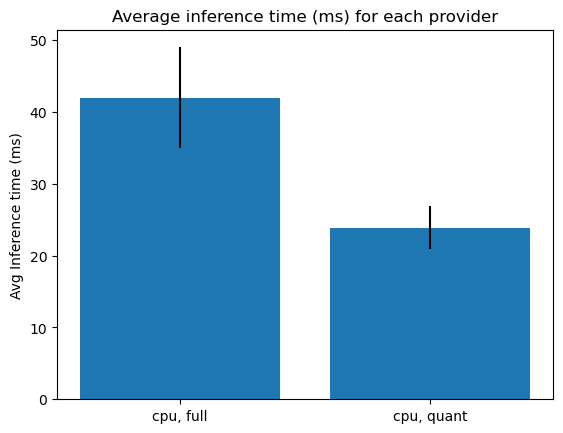

In [11]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.set_ylabel("Avg Inference time (ms)")
ax.set_title("Average inference time (ms) for each provider")
ax.bar(times_mean.keys(), times_mean.values(), yerr=times_std.values())
plt.show()

## ONNX

In [12]:
!rm -rf onnx/

convert(framework="pt", model=model_name, output=Path("onnx/model.onnx"), opset=onnx_opset)

opt_options = BertOptimizationOptions('bert')
opt_options.enable_embed_layer_norm = False

opt_model = optimizer.optimize_model(
    'onnx/model.onnx',
    'bert', 
    num_heads=12,
    hidden_size=768,
    optimization_options=opt_options)
opt_model.save_model_to_file('bert.opt.onnx')

ONNX opset version set to: 12
Loading pipeline (model: nlptown/bert-base-multilingual-uncased-sentiment, tokenizer: nlptown/bert-base-multilingual-uncased-sentiment)
Creating folder onnx
Using framework PyTorch: 1.6.0+cu92
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input token_type_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch', 1: 'sequence'}
Found output output_1 with shape: {0: 'batch'}
Ensuring inputs are in correct order
position_ids is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask', 'token_type_ids']


/opt/conda/envs/fastai/lib/python3.8/site-packages/transformers/models/bert/modeling_bert.py:194: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  position_ids = self.position_ids[:, past_key_values_length : seq_length + past_key_values_length]
/opt/conda/envs/fastai/lib/python3.8/site-packages/transformers/modeling_utils.py:1759: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert all(


In [13]:
name = 'onnx, cpu, full'
provider = "CPUExecutionProvider"
model_onnx = create_model_for_provider("onnx/model.onnx", provider)
pipe = ONNXPipeline(model_onnx, tokenizer)

times_mean[name], times_std[name] = time_pipeline(pipe)

100%|██████████| 100/100 [00:01<00:00, 57.83it/s]


In [14]:
name = 'onnx, cpu, quant'

quantized_model_path = quantize(Path("bert.opt.onnx"))
quantized_model = create_model_for_provider(quantized_model_path.as_posix(), "CPUExecutionProvider")

pipe = ONNXPipeline(quantized_model, tokenizer)
times_mean[name], times_std[name] = time_pipeline(pipe)

As of onnxruntime 1.4.0, models larger than 2GB will fail to quantize due to protobuf constraint.
This limitation will be removed in the next release of onnxruntime.
         Please use quantize_static for static quantization, quantize_dynamic for dynamic quantization.
Quantized model has been written at bert.onnx: ✔


100%|██████████| 100/100 [00:00<00:00, 102.94it/s]


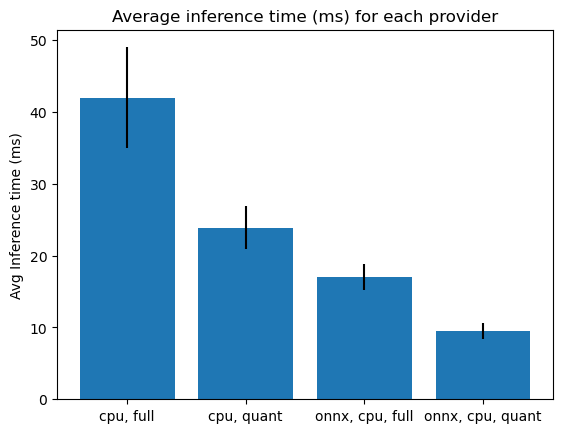

In [15]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.set_ylabel("Avg Inference time (ms)")
ax.set_title("Average inference time (ms) for each provider")
ax.bar(times_mean.keys(), times_mean.values(), yerr=times_std.values())
plt.show()

In [16]:
times_mean["cpu, full"]/times_mean["onnx, cpu, quant"]

4.394621729774059

In [29]:
%%timeit
prompt='Transformers are great!'
model_inputs = tokenizer(prompt, return_tensors="pt")
inputs_onnx = {k: v.cpu().detach().numpy() for k, v in model_inputs.items()}

156 µs ± 2.62 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
from torch.onnx.symbolic_helper import _onnx_master_opset, _onnx_stable_opsets
_onnx_master_opset, _onnx_stable_opsets

(10, [7, 8, 9, 10, 11, 12])

In [21]:
import sys
!{sys.executable} -m pip freeze

adal==1.2.5
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1605217004767/work
async-generator==1.10
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
azure-cognitiveservices-search-imagesearch==2.0.0
azure-common==1.1.26
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1600454382015/work
blis==0.4.1
brotlipy==0.7.0
catalogue @ file:///home/conda/feedstock_root/build_artifacts/catalogue_1605613584677/work
certifi==2020.11.8
cffi @ file:///home/conda/feedstock_root/build_artifacts/cffi_1602537222527/work
chardet @ file:///home/conda/feedstock_root/build_artifacts/chardet_1602255302199/work
click==7.1.2
coloredlogs==15.0
cryptography @ file:///home/conda/feedstock_root/build_artifacts/cryptography_1604179079864/work
cycler==0.10.0
cymem @ file:///home/conda/feedstock_root/build_artifacts